# A Neural Engineering Framework Representation of the Kalman Filter
## Introduction
The Kalman Filter is a method for estimating unknown or hidden system states using an internal model of the physical processes at work. First we need to construct the physical process that we are trying to find estimates for. Modelling kinematic motion can be done through state space equation in discrete time using simple forward integration. For system dynamics in the horizontal axis of the 2D plane let $$x[n+1] = x[n] + \dot{x} * dt$$ and system dynamics in the vertical axis be $$y[n+1] = y[n] + \dot{y}[n] * dt$$ where $$\dot{y}[n+1] = \dot{y}[n] + \ddot{y} * dt$$ The State Variables that we want to estimate are going to be $x[n], \dot{x}[n], y[n], \dot{y}[n], \ddot{y}[n]$. In state space this gives us 
$$
 \begin{bmatrix}
 x[n+1] \\
 \dot{x}[n+1] \\
 y[n+1] \\
 \dot{y}[n+1] \\
 \ddot{y}[n+1]
 \end{bmatrix}
 =
 \begin{bmatrix}
 1 & dt & 0 & 0 & 0 \\
 0 & 1 & 0 & 0 & 0 \\
 0 & 0 & 1 & dt & 0 \\
 0 & 0 & 0 & 1 & dt \\
 0 & 0 & 0 & 0 & 1
 \end{bmatrix}
 \begin{bmatrix}
 x[n] \\
 \dot{x}[n] \\
 y[n] \\
 \dot{y}[n] \\
 \ddot{y}[n]
 \end{bmatrix}
$$
The noisy measurement values that we are able to observe will be $x[n]$ and $y[n]$. Using the kalman filter we will both be able to achieve some degree of tracking and estimate the true values of the rest of the states through added gaussian noise.

In [1]:
import nengo
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def system_dynamics(x, dt):
    A = np.array([
        [1, dt, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, dt, 0],
        [0, 0, 0, 1, dt],
        [0, 0, 0, 0, 1]
    ])
    next_state = A @ x
    return next_state

def output_from_state(x):
    C = np.array([[1, 0, 0, 0, 0], [0, 0, 1, 0, 0]])
    return C @ x

def kalman_filter_trad(x_hat, next_y, dt):
    variance_y = 1
    variance_x = (1/10)**2
    A = np.array([
        [1, dt, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, dt, 0],
        [0, 0, 0, 1, dt],
        [0, 0, 0, 0, 1]
    ])
    
    C = np.array([[1, 0, 0, 0, 0], [0, 0, 1, 0, 0]])
    
    K = np.linalg.inv((np.eye(2) + variance_x * C @ (variance_y ** -1 * C))) @ (variance_x * C.T * variance_y ** -1)
    
    next_x_hat = (np.eye(2) - K @ C) @ A @ x_hat + K @ next_y
    return next_x_hat


def kalman_filter(x_hat, next_y, dt, P):
    return kalman_filter_standard(x_hat, next_y, dt, P)
    
def kalman_filter_course(x_hat, next_y, dt):
    variance_y = 1
    variance_x = (1/10)**2
    A = np.array([
        [1, dt, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, dt, 0],
        [0, 0, 0, 1, dt],
        [0, 0, 0, 0, 1]
    ])
    C = np.array([[1, 0, 0, 0, 0], [0, 0, 1, 0, 0]])
    P = np.array((np.eye(5) / variance_x) + (np.dot(C.T, C) / variance_y))
    next_x_hat = np.linalg.inv(P) @ (((A @ x_hat) / variance_x) + ((C.T @ next_y)) / variance_y)
    return next_x_hat

def kalman_filter_standard(x_hat, next_y, dt, P):
    A = np.array([
        [1., dt, 0, 0, 0],
        [0, 1., 0, 0, 0],
        [0, 0, 1., dt, 0],
        [0, 0, 0, 1., dt],
        [0, 0, 0, 0, 1.]
    ])
    
    C = np.array([[1, 0, 0, 0, 0], [0, 0, 1, 0, 0]])
    
    x_super_minus = A @ x_hat
    P_super_minus = A @ P @ A.T
    
    K = P_super_minus @ C.T @ np.linalg.inv(C @ P_super_minus @ C.T + np.eye(2) * 1)
    new_P = (np.eye(5) - K @ C) @ P_super_minus
    return x_super_minus + K @ (next_y - C @ x_super_minus), new_P

In [3]:
t_length = 10
num_samples = 50000
t_space = np.linspace(0, t_length, num=num_samples)
dt = t_length / num_samples

# Create Random Noise
noise_mean = 0
noise_std = 1
P_prev = np.eye(5)
random_noise = np.random.normal(noise_mean, noise_std, (num_samples, 2, 1))
random_state_noise = np.random.normal(noise_mean, 0, (num_samples, 5, 1))

# Initialize state and output recorders
state_recorder = np.array([[[0], [2], [10], [0], [-9.81]] + random_state_noise[0]])
output_recorder = np.array([output_from_state(state_recorder[0]) + random_noise[0]]) 
prediction_recorder, P_prev = kalman_filter(np.array([[0, 0, 0, 0, 0]]).T, output_recorder[0], dt, P_prev) 
prediction_recorder = np.array([prediction_recorder])

# Initialize next state and next output
next_state = [system_dynamics(state_recorder[0], dt) + random_state_noise[1]]
next_output = [output_from_state(next_state[0]) + random_noise[1]]
next_estimate, P_prev = kalman_filter(prediction_recorder[0], next_output[0], dt, P_prev)
next_estimate = [next_estimate]

state_recorder = np.append(state_recorder, next_state, axis=0)
output_recorder = np.append(output_recorder, next_output, axis=0)
prediction_recorder = np.append(prediction_recorder, next_estimate, axis=0)

for _, (t, rand_n, rand_state_n) in enumerate(zip(t_space[2:], random_noise[2:, :], random_state_noise[2:, :])):
    next_state = [system_dynamics(next_state[0], dt) + rand_state_n]
    next_output = [output_from_state(next_state[0]) + rand_n]
    next_estimate, P_prev = kalman_filter(next_estimate[0], next_output[0], dt, P_prev)
    next_estimate = [next_estimate]
    
    state_recorder = np.append(state_recorder, next_state, axis=0)
    output_recorder = np.append(output_recorder, next_output, axis=0)
    prediction_recorder = np.append(prediction_recorder, next_estimate, axis=0)


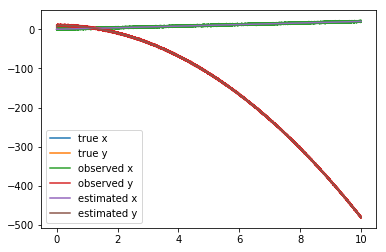

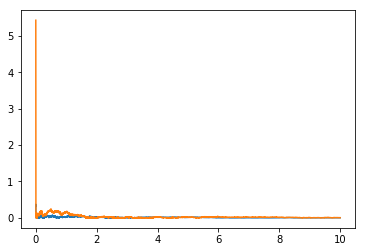

In [4]:
plt.figure()
plt.plot(t_space, np.squeeze(state_recorder[:, [0, 2]]))
plt.plot(t_space, np.squeeze(output_recorder))
plt.plot(t_space, np.squeeze(prediction_recorder[:, [0, 2]]))
plt.legend(['true x', 'true y', 'observed x', 'observed y', 'estimated x', 'estimated y'])
plt.figure()
plt.plot(t_space, np.absolute(np.squeeze(state_recorder[:, [0, 2]]) - np.squeeze(prediction_recorder[:, [0, 2]])))

## Neural Kalman filter constant velocity 1D
To begin the neural kalman filter, we will consider the 1-dimensional case with a constant velocity term. In discrete time the first order differential equation is $$x[n+1] = x[n] + \dot{x}[n]*dt$$ We take the position x as an input into an ensemble of neurons. In state space we have 
$$
\begin{bmatrix}
x[n+1] \\
\dot{x}[n+1]
\end{bmatrix}= 
\begin{bmatrix}
1 & dt \\
0 & 1
\end{bmatrix}
\begin{bmatrix}
x[n] \\
\dot{x}[n]
\end{bmatrix}
$$ In continuous time however, the system is simply $\dot{x} = const$. As input, our system will encode the position of an object moving at a constant velocity in 1-dimension and we will try to estimate the true value of the states $x$ and $\dot{x}$.

C:\Users\newho\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\newho\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\newho\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

RMSE: 0.13679158685654652


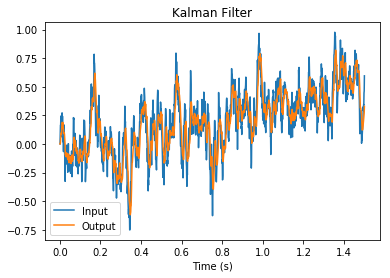

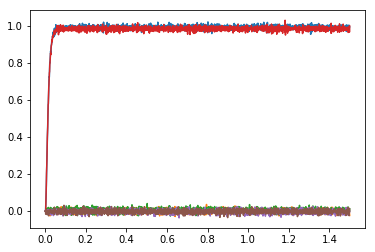

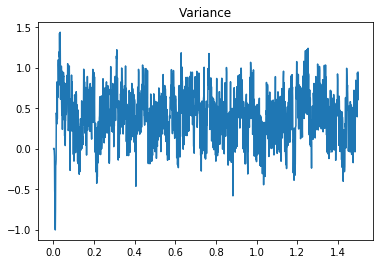

In [61]:
A = np.asarray([[0, 1], [0, 0]])
C = np.asarray([1, 0])
std_noise = 1
std_state = 1
my_func = lambda x:0.3 * x + np.random.normal(0, std_noise)
model = nengo.Network(label='Kalman Filter Network')
num_neurons = 200
# output_representation--> measurement
with model:
    position = nengo.Node(my_func)
    output_representation = nengo.Ensemble(num_neurons, dimensions=1)
    nengo.Connection(position, output_representation)
    
    input_position = nengo.Probe(position, synapse=0.01)
    probe_1 = nengo.Probe(output_representation, synapse=0.01)
    
    C_input = nengo.Node(C.ravel())
    C_ensemble = nengo.networks.EnsembleArray(num_neurons, C.size, radius=1)
    nengo.Connection(C_input, C_ensemble.input)
    C_probe = nengo.Probe(C_ensemble.output, synapse=0.01)
    
    C_squared = nengo.networks.Product(num_neurons, dimensions=C.size)
    
    nengo.Connection(C_ensemble.output, C_squared.A)
    nengo.Connection(C_ensemble.output, C_squared.B)
    
    C_squared_sum = nengo.Ensemble(num_neurons, dimensions=1)
    nengo.Connection(C_squared.output[0], C_squared_sum)
    nengo.Connection(C_squared.output[1], C_squared_sum)
    
    C_squared_probe = nengo.Probe(C_squared_sum, synapse=0.01)
    
    A_input = nengo.Node(A.ravel())
    A_ensemble = nengo.networks.EnsembleArray(num_neurons, A.size, radius=1)
    nengo.Connection(A_input, A_ensemble.input)
    A_probe = nengo.Probe(A_ensemble.output, synapse=0.01)
    
    sigma_squared_observation = nengo.Node(lambda x:std_noise**2)
    sigma_squared_state = nengo.Node(lambda x: std_state**2)
    
    sigma_representation_observation_inv = nengo.Ensemble(num_neurons, dimensions=1)
    nengo.Connection(sigma_squared_observation, sigma_representation_observation_inv, function=lambda x : 1/x)
    
    
    sigma_representation_state_inv = nengo.Ensemble(num_neurons, dimensions=1)
    nengo.Connection(sigma_squared_state, sigma_representation_state_inv, function=lambda x : 1/x)
    
    input_to_product = nengo.Ensemble(num_neurons*4, dimensions=2, radius=2)
    
    nengo.Connection(C_squared_sum, input_to_product[0])
    nengo.Connection(sigma_representation_observation_inv, input_to_product[1])
    
    prod = nengo.Ensemble(num_neurons*4, dimensions=1, radius=2)
    nengo.Connection(input_to_product, prod, function=lambda x: x[0] * x[1])
    
    P = nengo.Ensemble(num_neurons*4, dimensions=1, radius=2)
    nengo.Connection(prod, P)
    nengo.Connection(sigma_representation_state_inv, P)
    
    P_inv = nengo.Ensemble(num_neurons*4, dimensions=1, radius=2)
    nengo.Connection(P, P_inv, function=lambda x: 1/x)
    
    pinv_probe = nengo.Probe(P_inv, synapse=0.01)
    
    state_representation = nengo.Ensemble(num_neurons, dimensions=2)
    
    combined_observation_sigma = nengo.Ensemble(num_neurons, dimensions=2)
    nengo.Connection(output_representation, combined_observation_sigma[0])
    nengo.Connection(sigma_representation_observation_inv, combined_observation_sigma[1])
    product_obs_sigma = nengo.Ensemble(num_neurons, dimensions=1)
    nengo.Connection(combined_observation_sigma, product_obs_sigma, function=lambda x: x[0] * x[1])
    
    combined_A_sigma = nengo.networks.EnsembleArray(num_neurons, A.size, radius=2)
    
    for ens in A_ensemble.output:
        nengo.Connection()
    
    nengo.Connection(A.inputs)
    
    
with nengo.Simulator(model) as sim:
    sim.run(1.5)
plt.title("Step input")
plt.xlabel("Time (s)")
plt.plot(sim.trange(), sim.data[input_position])
plt.title("Kalman Filter")
plt.xlabel("Time (s)")
plt.plot(sim.trange(), sim.data[probe_1])
plt.legend(['Input', 'Output'])
plt.figure()
plt.plot(sim.trange(), sim.data[C_probe])
plt.plot(sim.trange(), sim.data[A_probe])
plt.figure()
plt.title('Variance')
plt.plot(sim.trange(), sim.data[pinv_probe])
rmse = np.sqrt(np.average((sim.data[probe_1]-sim.data[input_position])**2))
print(f'RMSE: {rmse}')